# Spike distance

In [1]:
from neo.core import SpikeTrain
from quantities import ms
import numpy as np
import pickle
import quantities as pq
from elephant.spike_train_dissimilarity import victor_purpura_distance
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.special import expit
from scipy.stats import wasserstein_distance
import matplotlib.patches as patches
import h5py
from scipy.signal import convolve
from scipy.interpolate import griddata
import pickle

def compute_emd_matrix(spike_trains):
    """
    Compute a pairwise EMD distance matrix for a list of spike trains.
    
    Parameters:
        spike_trains: list of lists, where each sublist is a spike train
    
    Returns:
        emd_matrix: 2D numpy array of shape (N, N) with pairwise EMD values
    """
    num_trials = len(spike_trains)
    emd_matrix = np.zeros((num_trials, num_trials))

    for i in range(num_trials):
        for j in range(i + 1, num_trials):  # Only compute upper triangle
            emd = wasserstein_distance(spike_trains[i], spike_trains[j])
            emd_matrix[i, j] = emd
            emd_matrix[j, i] = emd  # Symmetric matrix

    return emd_matrix

def plot_matrix(matrix, title="Pairwise EMD Distance Matrix"):
    """
    Plots a matrix as a heatmap using Matplotlib.

    Parameters:
        matrix: 2D numpy array to be visualized.
        title: Title of the plot.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap="coolwarm", aspect="auto")
    plt.colorbar(label="EMD Distance")
    plt.title(title)
    plt.xlabel("Trial Index")
    plt.ylabel("Trial Index")
    plt.show()
    
def block_means(matrix,n_groups, group_size):
# Initialize an array to store the averaged values.
    block_means = np.zeros((n_groups, n_groups))

    # Loop through each block, compute its mean, and store it.
    for i in range(n_groups):
        for j in range(n_groups):
            
            block = matrix[i*group_size:(i+1)*group_size, j*group_size:(j+1)*group_size]
            # Compute the average of the block.
            block_means[i, j] = block.mean()
    return block_means

def block_stats_all(matrix, n_real):

    real_real = matrix[0:n_real, 0:n_real]
    real_model = matrix[0:n_real, n_real:]
    model_model = matrix[n_real:, n_real:]
    
    stats = []
    for label, block in zip(["Real–Real", "Real–Model", "Model–Model"],
                              [real_real, real_model, model_model]):
        mean_val = block.mean()
        range_val = block.max() - block.min()
        std_val = block.std()
        cv_val = std_val / mean_val if mean_val != 0 else 0
        stats.append([label, f"{mean_val:.2f}", f"{range_val:.2f}", f"{std_val:.2f}", f"{cv_val:.2f}"])
    return stats

def plot_matrixcat_and_stats(matrix, title="Pairwise EMD Distance Matrix", n_real=None, n_model=None, group_size=None):
    """
    Plots a heatmap of the matrix with:
      - A category bar above (dividing trials into "Real" and "Model").
      - (Optional) Block mean annotations inside the heatmap if group_size is provided.
      - A table below the heatmap displaying statistics computed for three blocks:
            • Real–Real (real vs. real)
            • Real–Model (real vs. model)
            • Model–Model (model vs. model)
      
      The table columns are: Block, Mean, Range, Std, and CV (with CV as the last column).
    
    Parameters:
      - matrix: 2D numpy array (assumed square).
      - title: Title for the heatmap.
      - n_real: Number of real trials (left portion). Defaults to half the number of columns.
      - n_model: Number of model trials (right portion). Defaults to the remainder.
      - group_size: If provided, used for annotating the heatmap with block means.
                    For a 2x2 division of a square matrix, use group_size = matrix.shape[0]//2.
    """
    # Total number of trials (columns)
    N = matrix.shape[1]
    if n_real is None or n_model is None:
        n_real = N // 2
        n_model = N - n_real

    # Create the main heatmap with colorbar.
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(matrix, cmap="coolwarm", aspect="auto")
    ax.set_xlabel("Trial Index")
    ax.set_ylabel("Trial Index")
    ax.set_title(title, fontsize=12, pad=30)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="EMD Distance")

    # Get the position of the heatmap axis.
    pos = ax.get_position()
    gap_val = 0.005         # Vertical gap between the heatmap and the category bar.
    cat_bar_height = 0.03     # Height of the category bar.

    # Create a new axis above the heatmap for the category bar.
    cat_ax = fig.add_axes([pos.x0, pos.y0 + pos.height + gap_val, pos.width, cat_bar_height])
    cat_ax.set_xlim(0, N)
    cat_ax.set_ylim(0, 1)
    cat_ax.axis("off")

    # Define a gap (in trial units) between the two black bars.
    gap = 2  
    real_width = n_real - gap / 2
    model_width = n_model - gap / 2

    # Draw the "Real" bar (black) covering the real trials.
    cat_ax.add_patch(patches.Rectangle((0, 0), real_width, 0.21, facecolor="black"))
    # Draw the "Model" bar (black) covering the model trials.
    cat_ax.add_patch(patches.Rectangle((n_real + gap/2, 0), model_width, 0.21, facecolor="black"))

    # Add text labels over each bar.
    cat_ax.text(real_width / 2, 0.5, "Real", ha="center", va="bottom", fontsize=10, fontweight="bold", color="black")
    cat_ax.text(n_real + gap/2 + model_width / 2, 0.5, "Model", ha="center", va="bottom", fontsize=10, fontweight="bold", color="black")

    # Create an axis for the statistics table below the heatmap.
    table_height = 0.15  # Adjust table height as needed.
    table_ax = fig.add_axes([pos.x0, pos.y0 - table_height - 0.1, pos.width, table_height])
    table_ax.axis('off')
    
    # Compute block statistics for three blocks.
    stats = block_stats_all(matrix, n_real)
    column_labels = ["Block", "Mean", "Range", "Std", "CV"]
    cell_text = stats  # Each row: [Block, Mean, Range, Std, CV]
    
    table = table_ax.table(cellText=cell_text, colLabels=column_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    table_ax.set_title("Block Statistics", fontsize=12, pad=10)
    
    plt.show()

def generate_stimuli(trajx, trajy,board_size=400, diameter=30,fps = 60,pretime = 50,tailtime =50,type='natural',preframes=15,tailframes=45,stimframes=15):
    stimuli = []
    dt = 1/fps

    board_range = [-(board_size/2), (board_size/2)]  
    radius = diameter / 2  

    x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
    y_vals = np.linspace(board_range[0], board_range[1], board_size+1)
    X, Y = np.meshgrid(x_vals, y_vals)
    
    if type == 'natural':
        if len(trajx) != len(trajy):
            raise ValueError("trajx and trajy must have the same length.")
        if len(trajx) == 0:
            raise ValueError("Trajectory arrays must not be empty.")

        preframenum = int(pretime / 1000 /dt)
        tailframenum = int(tailtime / 1000 /dt)
        for _ in range(preframenum):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            stimuli.append(frame)   
        
        for frame_idx, (x, y) in enumerate(zip(trajx, trajy)):
            # if frame_idx < preframenum or frame_idx >= (len(trajx) - tailframenum):
            #     # Draw blank
            #     frame = np.zeros((board_size, board_size), dtype=np.uint8)
            # else:
                # Draw the circle
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            mask = (X - x) ** 2 + (Y - y) ** 2 <= radius ** 2
            frame[mask] = 1

            stimuli.append(frame)   
            
        for _ in range(tailframenum):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            stimuli.append(frame)   
    if type == 'spotfield':
        if len(trajx) != len(trajy):
            raise ValueError("trajx and trajy must have the same length.")
        if len(trajx) == 0:
            raise ValueError("Trajectory arrays must not be empty.")

    
        for section_idx, (x, y) in enumerate(zip(trajx, trajy)):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            for _ in range(preframes):
                stimuli.append(frame)   
                
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            mask = (X - x) ** 2 + (Y - y) ** 2 <= radius ** 2
            frame[mask] = 1
            for _ in range(stimframes):
                stimuli.append(frame)   
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            for _ in range(tailframes):
                stimuli.append(frame)   
        
    return np.array(stimuli)


def spatial_filterSF(rf,A=0.2):
    return A * rf

def gaussian_2d(x, y, sigma_x, sigma_y, A=0.2, x0=0, y0=0):
    X, Y = np.meshgrid(x, y, indexing='ij')
    return A * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))


def difference_of_gaussians(x, y, sigma_c, sigma_s, A_c=0.4, A_s=0.2):
    X, Y = np.meshgrid(x, y, indexing='ij')
    center = A_c * np.exp(-(X**2 + Y**2) / (2 * sigma_c**2))
    surround = A_s * np.exp(-(X**2 + Y**2) / (2 * sigma_s**2))
    return center - surround

def biphasic_temporal_filter(t, 
                             t_neg=40, t_pos=400, t_peak=120, 
                             sigma_neg=18, sigma_pos=56,
                             rel_ampli=1):
    t_shifted = t - t[0]

    # Negative phase
    negative_phase = - (t_shifted / t_neg) \
                     * np.exp(-((t_shifted - t_neg)**2)/(2*sigma_neg**2))

    # Positive phase
    positive_phase =  (t_shifted / t_pos) \
                     * np.exp(-((t_shifted - t_peak)**2)/(2*sigma_pos**2))

    temporal_filter = rel_ampli*negative_phase + (positive_phase)

    # Normalize so the max abs value is 1
    temporal_filter /= np.max(np.abs(temporal_filter))
    return temporal_filter

def apply_temporal_filter_to_movie(movie, temporal_filter):

    F, = movie.shape  
    T = len(temporal_filter) 

    filtered_movie = np.zeros_like(movie)

    filtered_signal = convolve(movie, temporal_filter, mode='full')[:F]
    
    filtered_movie[:] = filtered_signal

    return filtered_movie

def linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s, A_c, A_s , noise_input, temporal_filter, type,rf_estimated):   

    T, Y, X = noise_input.shape 
    x = np.linspace(-(X-1)/2, (X-1)/2, X)
    y = np.linspace(-(Y-1)/2, (Y-1)/2, Y)
    noise_input = noise_input.astype(np.float32)
    
    if type == 'gaussian':
        spatial_rf = gaussian_2d(x, y, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
    if type == 'difference_of_gaussians':
        spatial_rf = difference_of_gaussians(x, y, sigma_c, sigma_s, A_c, A_s)  # Shape: (Y,X)
    if type == 'SFfitting':
        spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    spatial_rf = spatial_rf.astype(np.float32)   
    spatial_filtered_movie = noise_input.reshape((T,Y*X)) @ spatial_rf.reshape((Y*X))  # Shape: (T,)
    filtered_movie = apply_temporal_filter_to_movie(spatial_filtered_movie, temporal_filter)

    return filtered_movie

def apply_nonlinearity(linear_output, method='static', **kwargs):
    if method == 'static':
        return np.maximum(0, linear_output)
    elif method == 'sigmoid':
        gain = kwargs.get('gain', 0.02)
        max_rate = kwargs.get('max_rate', 250.0)
        C = kwargs.get('y', -30)
        return max_rate * expit(gain * (linear_output + C))
    elif method == 'sigmoidgc':
        gain = kwargs.get('gain', 0.05)
        max_rate = kwargs.get('max_rate', 1500.0)
        C = kwargs.get('y', -37256.659)
        return max_rate / (0.04 + np.exp(-gain * (linear_output+165)))  + C
    elif method == 'threshold_linear':
        theta = kwargs.get('theta', 10)
        return np.maximum(0, linear_output - theta)
    elif method == 'threshold_lineargc':
        theta = kwargs.get('theta', 0)
        return np.maximum(0, linear_output - theta)
    elif method == 'powerlaw':
        gamma = kwargs.get('gamma', 0.5)
        return np.maximum(0, np.abs(linear_output)**gamma)
    elif method == 'exponential_saturation':
        alpha = kwargs.get('alpha', 0.1)
        beta = kwargs.get('beta', 1.0)
        return beta * (1 - np.exp(-alpha * linear_output))
    elif method == 'adaptive_gain':
        gain = kwargs.get('gain', 1.0)
        return gain * np.maximum(0, linear_output)
    else:
        raise ValueError("Unknown nonlinearity method")
    



# Gain control definition
def resample_and_generate_spikes(firing_rates, target_time_bin=1/1200):


    original_time_bin = 1 / 60

    upsampling_factor = int(original_time_bin / target_time_bin)
    if upsampling_factor < 1:
        raise ValueError("Target time bin must be smaller")

    expanded_firing_rates = np.repeat(firing_rates, upsampling_factor, axis=0)


    scaled_rates = expanded_firing_rates * target_time_bin


    spikes = np.random.poisson(scaled_rates)

    return spikes

def gain_control(Lout, B=0.005, tau=11.0):

    T = len(Lout)  
    v_t = np.zeros(T)  
    g_v = np.zeros(T)
    gain_controlled_Lout = np.zeros(T) 
    gain_controlled_Lout[0] = 1 * Lout[0]
    decay_kernel = B * np.exp(-np.arange(T) / tau)

    for t in range(T):
        v_t[t] = np.sum(gain_controlled_Lout[:t] * decay_kernel[:t][::-1]) 
        g_v[t] = 1 if v_t[t] < 0 else 1 / (1 + v_t[t]**4)
        gain_controlled_Lout[t] = g_v[t] * Lout[t]

    return gain_controlled_Lout, g_v


rf_estimated = np.load('rf_estimated.npy')
with open('spike_trainGC.pkl', 'rb') as f:
    spike_trainGC = pickle.load(f)


with open('spike_indices_n.pkl', 'rb') as f:
    spike_indices_n = pickle.load(f)

with open('spike_indices_c.pkl', 'rb') as f:
    spike_indices_c = pickle.load(f)



# spike_indicesModified_n = spike_indices_n.copy()
spike_indicesModified_c = spike_indices_c.copy()
# spike_indicesModified_n[4] = spike_indices_n[4]-800
# spike_indicesModified_n[45] = spike_indices_n[45]-800
spike_indicesModified_c[34] = spike_indices_c[34]-800

# model PARAM

In [2]:
delay = 0.083 # s
# Parameter settting for model
temporal_filter_noise = np.load('temporal_filter5.npy')
reversed_temp_rfTemp = temporal_filter_noise[::-1]
# stimuli_n = np.load('stimuli_n.npy')
stimuli_c = np.load('stimuli_c.npy')
# parameters for the LN-GC 
stimuli = stimuli_c
spike_indices = spike_indicesModified_c
t_sampling = np.linspace(0,1860,1860)


time_para = 5400 # time bin to generate spike
num_modeltrails = 60 #
# temporal filter 
# t_temporal = np.linspace(-500, 0, 30) 
# temp_rf = biphasic_temporal_filter(t_temporal, t_neg=60,t_pos=100, t_peak=400, sigma_neg=90, sigma_pos=20,rel_ampli=0.6)

# spatial filter
sigma_x, sigma_y = 70,70   #normal
sigma_c, sigma_s = 70, 140  #diff
A_c=0.4 # center
A_s=0.2 # surround

# gain control
# nonLinear filter
spatialtype = 'SFfitting'
gainGC = 0.04
max_rateGC = 1500
y_CGC = -37256.659
theta = 30
A       = 0.97964
B       = 0.0005486
tau     = 8.695
pnratio = 0.6252
gain = 0.00213
max_rate = 200
y = -800

reversed_temp_rf = np.concatenate((reversed_temp_rfTemp[0:8], reversed_temp_rfTemp[8:] * pnratio))

In [3]:

# model output
# LN model
spike_trainLN = []
LoutLN = linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s, A_c, A_s, stimuli, reversed_temp_rf, spatialtype, rf_estimated)
LNoutLN = apply_nonlinearity(apply_nonlinearity(LoutLN, method='sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = theta)

time_bin = 1/time_para
for trial in range(num_modeltrails):
    spikingindx=(resample_and_generate_spikes(LNoutLN, time_bin))
    spike_trainLN.append(np.where(spikingindx > 0))


#LN model with gain control
spike_trainGC = []
LoutGC = linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s, A_c, A_s, stimuli, reversed_temp_rf, spatialtype,rf_estimated)
LoutGC, g = gain_control(LoutGC, B, tau)
LNoutGC = apply_nonlinearity(apply_nonlinearity(LoutGC, 'sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = theta)
time_bin = 1/time_para
for trial in range(num_modeltrails):
    spikingindx=(resample_and_generate_spikes(LNoutGC, time_bin))
    spike_trainGC.append(np.where(spikingindx > 0))

# Spike distance and raster

In [4]:
spike_trains_n = []
spike_trains_model = []
spike_trains_nemd = []
spike_trains_modelemd = []
for trial_idx, spikes in enumerate(spike_indices):
    st_n = SpikeTrain(spikes.flatten() / 10 * ms, t_stop=31000)
    st_narray = spikes.flatten() / 10
    st_model = SpikeTrain(np.array(spike_trainGC[trial_idx]).flatten() /54*10 * ms, t_stop=31000)
    st_modelarray = np.array(spike_trainGC[trial_idx]).flatten() /54*10
    spike_trains_n.append(st_n)
    spike_trains_model.append(st_model)
    spike_trains_nemd.append(st_narray)
    spike_trains_modelemd.append(st_modelarray)

spike_trains = [spike_trains_n[i] for i in range(len(spike_trains_n)) if i % 2 == 1] + spike_trains_model[:30]
spike_trainsemd = [spike_trains_nemd[i] for i in range(len(spike_trains_nemd)) if i % 2 == 1] + spike_trains_modelemd[:30]
q = 1.0 / (100.0 * pq.ms)

In [5]:
emd_matrix = compute_emd_matrix(spike_trainsemd)
vp_f = victor_purpura_distance(spike_trains, q)

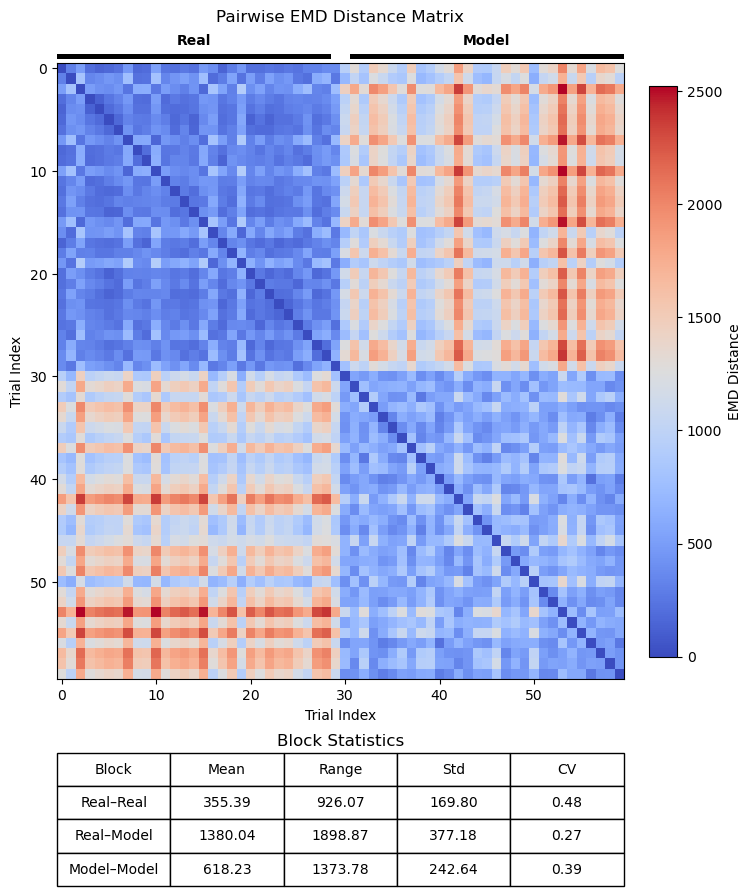

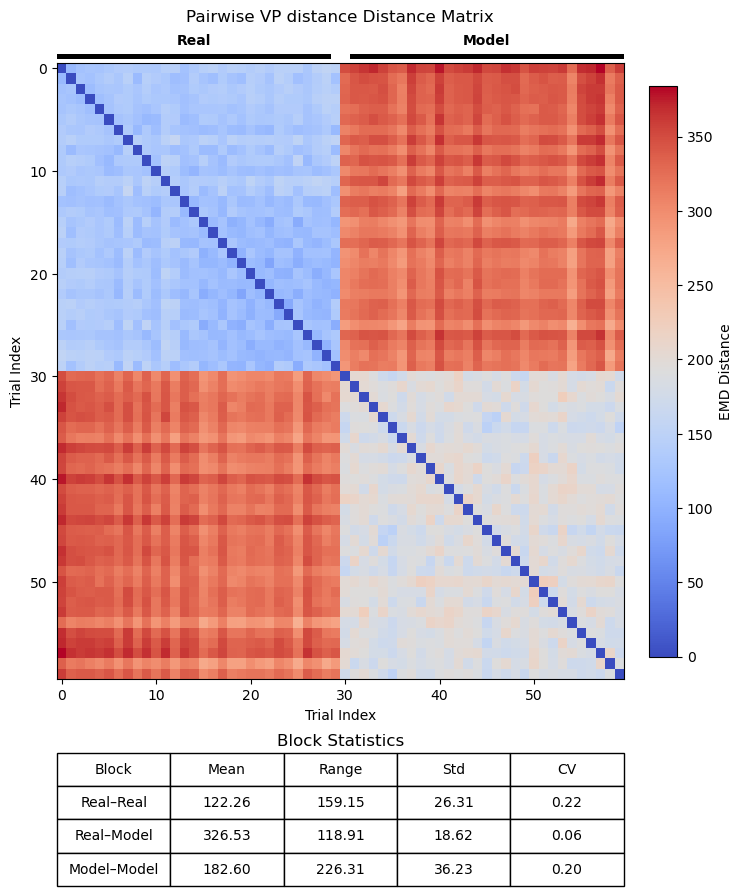

In [6]:
plot_matrixcat_and_stats(emd_matrix, title="Pairwise EMD Distance Matrix", n_real=30, n_model=30, group_size=30)
plot_matrixcat_and_stats(vp_f, title="Pairwise VP distance Distance Matrix", n_real=30, n_model=30, group_size=30)

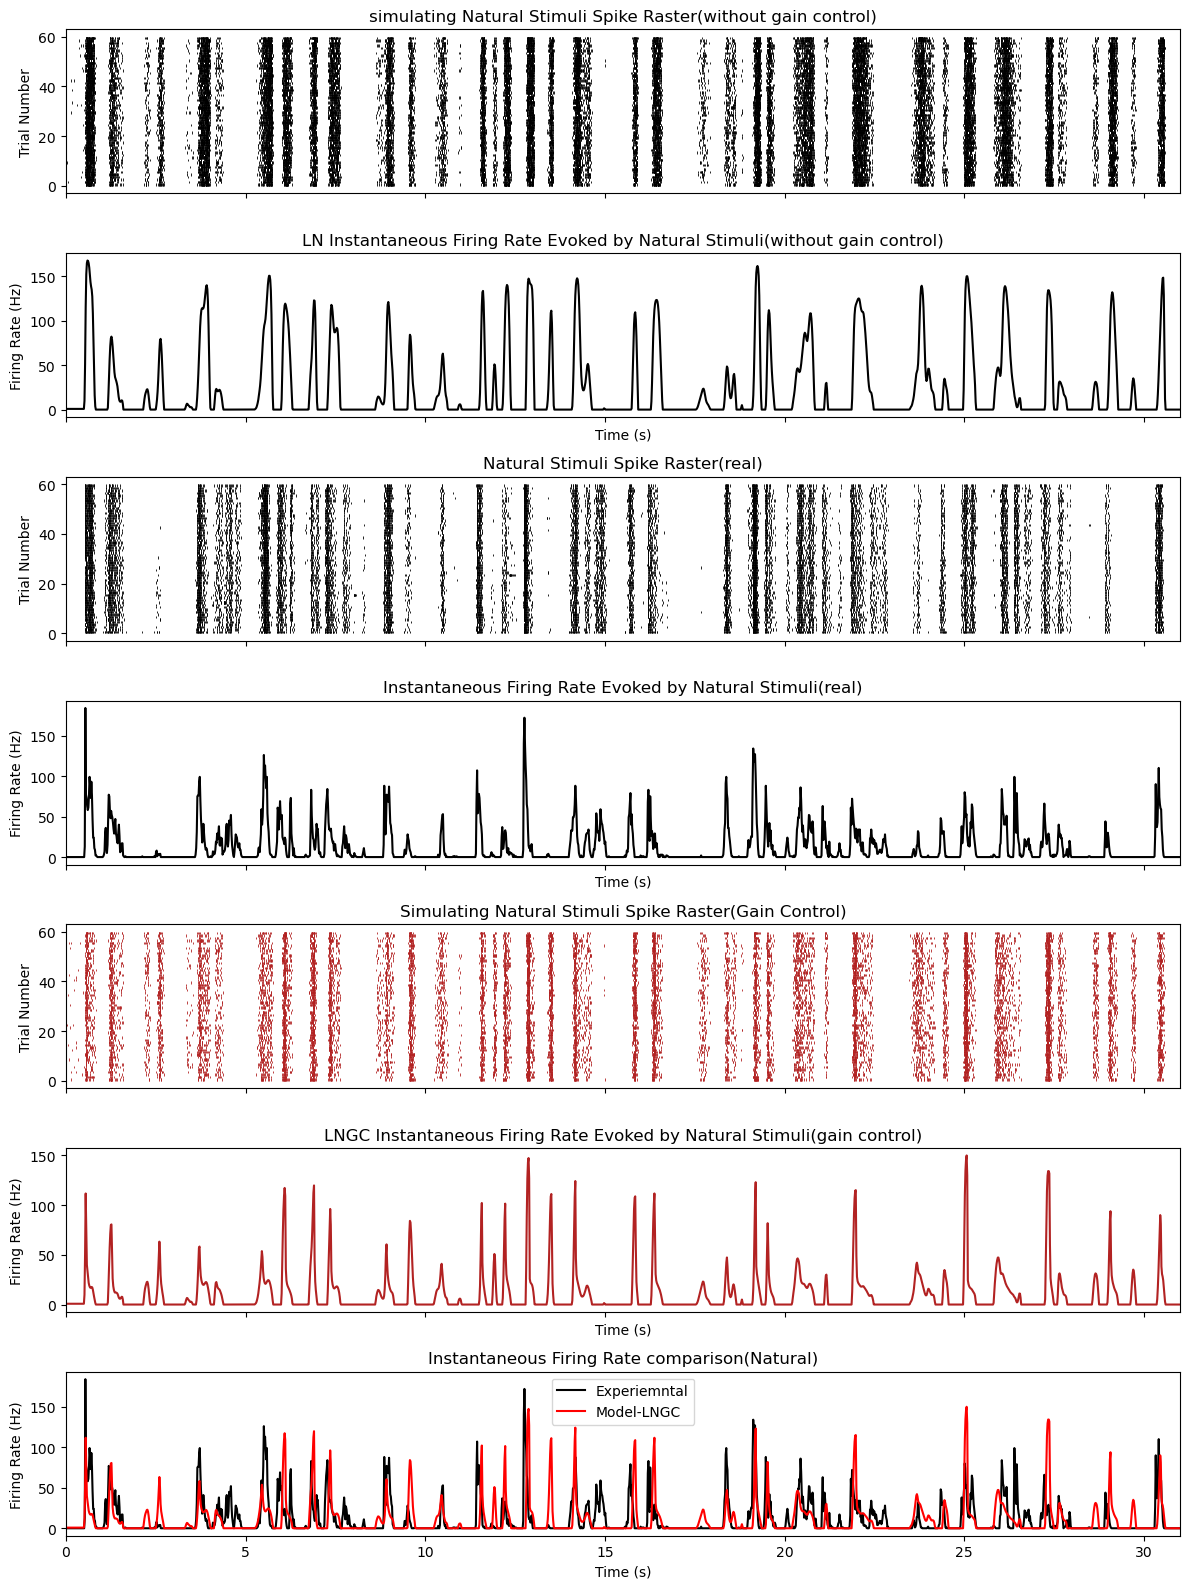

In [7]:
# plot for natural stimuli and gain control stimuli

fig, (ax1, ax2, ax3, ax4, ax5,ax6,ax7) = plt.subplots(7, 1, figsize=(12, 16), sharex=True)


num_trials_n = len(spike_indices)
spikes_n = []
for spike_idx_n in range(num_trials_n):
    spikes_in_trial = spike_indices[spike_idx_n] / 10000 - delay
    spikes_n.extend(spikes_in_trial)
    
spikes_n = np.array(spikes_n)


num_trials_modeln = len(spike_trainLN)

spikes_modeln = []
for spike_idx_n in range(num_trials_modeln):
    spikes_in_trial = np.array(spike_trainLN[spike_idx_n]) /time_para
    spikes_modeln.extend(spikes_in_trial)
    ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

ax1.set_ylabel('Trial Number')
ax1.set_title('simulating Natural Stimuli Spike Raster(without gain control)')
ax1.set_xlim(0, 31)  

ax2.plot(t_sampling/60, LNoutLN, 'k')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Firing Rate (Hz)')
ax2.set_title('LN Instantaneous Firing Rate Evoked by Natural Stimuli(without gain control)')


spikes_modeln = []
for spike_idx_n in range(num_trials_modeln):
    spikes_in_trial = np.array(spike_trainGC[spike_idx_n]) /time_para
    spikes_modeln.extend(spikes_in_trial)
    ax5.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'firebrick', linewidth=0.6)

ax5.set_ylabel('Trial Number')
ax5.set_title('Simulating Natural Stimuli Spike Raster(Gain Control)')
ax5.set_xlim(0, 31)  

ax6.plot(t_sampling/60, LNoutGC, 'firebrick')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Firing Rate (Hz)')
ax6.set_title('LNGC Instantaneous Firing Rate Evoked by Natural Stimuli(gain control)')

bin_width = 1/60 # s
bins = np.arange(0, 31 + bin_width, bin_width) 
counts_n, bin_edges = np.histogram(spikes_n, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
num_trials_n = len(spike_indices)
spikes_n = []
for spike_idx_n in range(num_trials_n):
    spikes_in_trial = spike_indices[spike_idx_n] / 10000 - delay
    spikes_n.extend(spikes_in_trial)
    ax3.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)




ax3.set_ylabel('Trial Number')
ax3.set_title('Natural Stimuli Spike Raster(real)')
ax3.set_xlim(0, 31)  

average_spike_count_n = counts_n / num_trials_n
firing_rate_n = average_spike_count_n / bin_width

ax4.plot(bin_centers, firing_rate_n, 'k')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Firing Rate (Hz)')
ax4.set_title('Instantaneous Firing Rate Evoked by Natural Stimuli(real)')

ax7.plot(bin_centers, firing_rate_n, 'k',label='Experiemntal')
ax7.plot(t_sampling/60, LNoutGC, 'r',label='Model-LNGC')
# ax7.plot(t_sampling/60, LNoutLN, 'b',label='Model-LN')
ax7.set_xlabel('Time (s)')
ax7.set_ylabel('Firing Rate (Hz)')
ax7.set_title('Instantaneous Firing Rate comparison(Natural)')
ax7.legend()
plt.tight_layout()
plt.show()

# optimization

In [9]:
# Load data and define fixed parameters.

theta = 30
A     = 0.8923
B     = 0.000505
tau   = 8.13
pnratio = 0.631
gain = 0.00213
max_rate = 200
y = -800
def objectiveEMD(params, train=True):
    try:
        A, B, tau, pnratio = params
        # Modify the receptive field using the pnratio.
        reversed_temp_rf_fit = np.concatenate((reversed_temp_rfTemp[0:8], reversed_temp_rfTemp[8:] * pnratio))
        
        # Generate model spike trains.
        spike_trainGCfit = []
        LoutGCfit = linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s, 
                                  A_c, A_s, stimuli, reversed_temp_rf_fit, 'SFfitting', rf_estimated)
        LoutGCfit, g = gain_control(LoutGCfit, B, tau)
        LNoutGCfit = apply_nonlinearity(
            apply_nonlinearity(LoutGCfit, 'sigmoid', gain=gain, max_rate=max_rate, y=y),
            method='threshold_linear', theta=theta
        )
        time_bin = 1 / time_para

        # Generate spike trains over 30 trials.
        for trial in range(30): 
            spikingindx = resample_and_generate_spikes(LNoutGCfit, time_bin)
            spike_trainGCfit.append(np.where(spikingindx > 0)[0])
        
        # Convert spike indices into model spike train arrays.
        spike_trains_modelemdfit = []
        for spikes in spike_trainGCfit:
            st_modelarray = np.array(spikes).flatten() / 54 * 10
            spike_trains_modelemdfit.append(st_modelarray)

        # Choose the reference (real) spike trains based on the flag.
        if train:
            reference_spike_trains = [spike_trains_nemd[i] for i in range(len(spike_trains_nemd)) if i % 2 == 0]
        else:
            reference_spike_trains = [spike_trains_nemd[i] for i in range(len(spike_trains_nemd)) if i % 2 == 1]
 
        # Combine reference spike trains with the model's spike trains.
        spike_trainsfit = reference_spike_trains + spike_trains_modelemdfit

        # Check for empty spike trains.
        for st in spike_trainsfit:
            if len(st) == 0:
                return 1e10

        score_matrix = compute_emd_matrix(spike_trainsfit)
        scores = block_means(score_matrix, 2, 30)
        score = scores[0, 1]
        return score

    except Exception as e:
        print("Error in objectiveEMD with params", params, ":", e)
        return 1e10

def objectiveVP(params, train=True):

    try:
        A, B, tau, pnratio = params
        # Adjust the temporal filter with the pnratio.
        reversed_temp_rf_fit = np.concatenate((reversed_temp_rfTemp[0:8], reversed_temp_rfTemp[8:] * pnratio))
        
        spike_trainGCvpfit = []
        spike_trains_modelvp = []
        LoutGCvpfit = linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s,
                                  A_c, A_s, stimuli, reversed_temp_rf_fit, 'SFfitting', rf_estimated)
        LoutGCvpfit, g = gain_control(LoutGCvpfit, B, tau)
        LNoutGCvpfit = apply_nonlinearity(
            apply_nonlinearity(LoutGCvpfit, 'sigmoid', gain=gain, max_rate=max_rate, y=y),
            method='threshold_linear', theta=theta)
        time_bin = 1 / time_para

        # Generate 30 model spike trains.
        for trial in range(30):
            spikingindx = resample_and_generate_spikes(LNoutGCvpfit, time_bin)
            spike_trainGCvpfit.append(np.where(spikingindx > 0)[0])
            st_modelvp = SpikeTrain(np.array(spike_trainGCvpfit[trial]).flatten() / 54 * 10 * ms,t_stop=31000)
            spike_trains_modelvp.append(st_modelvp)
 
        # Select the appropriate real data trials.
        if train:
            real_spike_trains = [spike_trains_n[i] for i in range(len(spike_trains_n)) if i % 2 == 0]
        else:
            real_spike_trains = [spike_trains_n[i] for i in range(len(spike_trains_n)) if i % 2 == 1]
        
     
        # Combine the real and model-generated spike trains.
        spike_trainsvpfit = real_spike_trains + spike_trains_modelvp
        
        # Check for empty spike trains.
        for st in spike_trainsvpfit:
            if len(st) == 0:
                return 1e10

        # Compute the Victor-Purpura distance and block means.
        vp_matrix = victor_purpura_distance(spike_trainsvpfit, q)
        scoresvp = block_means(vp_matrix, 2, 30)
        scorevp = scoresvp[0, 1]
        return scorevp

    except Exception as e:
        print("Error in objectiveVP with params", params, ":", e)
        return 1e10

# Define bounds for A, B, tau, and pnratio.
bounds = [(0.1, 1), (0.0005, 1), (8, 25), (0.5, 3)]

# Prepare lists to store iteration data.
iterations = []
errors_train = []
errors_eval = []

def callbackF(xk, convergence):
    # Record current iteration number.
    iteration = len(iterations) + 1
    # Compute errors on training and evaluation sets.
    train_error = objectiveEMD(xk, train=True)
    eval_error = objectiveEMD(xk, train=False)
    iterations.append(iteration)
    errors_train.append(train_error)
    errors_eval.append(eval_error)
    print(f"Iteration {iteration}: Training Error = {train_error}, Evaluation Error = {eval_error}")

# Run differential evolution using only the training set.
result_de = differential_evolution(
    lambda params: objectiveEMD(params, train=True),
    bounds,
    strategy="rand1bin",
    maxiter=8,
    mutation=(0.5, 1),
    recombination=0.95,
    disp=True,
    callback=callbackF,
)

optimal_A, optimal_B, optimal_tau, optimal_pnratio = result_de.x

print("Optimal parameters found:")
print("A       =", optimal_A)
print("B       =", optimal_B)
print("tau     =", optimal_tau)
print("pnratio =", optimal_pnratio)

# Plot both training and evaluation error curves over iterations.
plt.figure(figsize=(10, 6))
plt.plot(iterations, errors_train, label="Training Error", marker='o')
plt.plot(iterations, errors_eval, label="Evaluation Error", marker='o')
plt.xlabel("Iterations")
plt.ylabel("Error (Lower is Better)")
plt.title("Error vs. Iterations During Optimization")
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(70, 16))
plt.plot(iterations, errors_train, label="Training Error", marker='o')
plt.plot(iterations, errors_eval, label="Evaluation Error", marker='o')
plt.xlabel("Iterations")
plt.ylabel("Error (Lower is Better)")
plt.title("Error vs. Iterations During Optimization")
plt.legend()
plt.grid(True)
plt.show()

# value for next optimization

In [ ]:
theta = 30
A       = 0.97964
B       = 0.0005486
tau     = 8.695
pnratio = 0.6252
gain = 0.00213
max_rate = 200
y = -800

reversed_temp_rf_fit = np.concatenate((reversed_temp_rfTemp[0:8], reversed_temp_rfTemp[8:] * pnratio))

# Generate spike train
spike_trainGCfit = []
LoutGCfit = linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s, A_c, A_s, stimuli, reversed_temp_rf_fit, spatialtype, rf_estimated)
LoutGCfit, g = gain_control(LoutGCfit, B, tau)
LNoutGCfit = apply_nonlinearity(apply_nonlinearity(LoutGCfit, 'sigmoid', gain=gain, max_rate=max_rate, y=y), method='threshold_linear', theta=theta)
time_bin = 1 / time_para

for trial in range(30):  # Single trial for optimization
    spikingindx = resample_and_generate_spikes(LNoutGCfit, time_bin)
    spike_trainGCfit.append(np.where(spikingindx > 0))
spike_trains_modelemdfit = []
for trial_idx, spikes in enumerate(spike_trainGCfit):
    st_modelarray = np.array(spikes).flatten() /54*10
    spike_trains_modelemdfit.append(st_modelarray)

# Convert spike trains to arrays for EMD
spike_trainsfit = [spike_trains_nemd[i] for i in range(len(spike_trains_nemd)) if i % 2 == 1] + spike_trains_modelemdfit
# Compute EMD as the objective function
score = compute_emd_matrix(spike_trainsfit)
scores = block_means(score,2,30)


In [ ]:
scores

# nonlinearity opt on VP distance

In [ ]:
# A       = 0.6259386802009455
# B       = 0.0005191171052243981
# tau     = 11.322612574159745
# pnratio = 0.5296426963852245
def objectiveNLVP(params, train=True):
    """
    Optimize the non-linear parameters (gain, max_rate, y) while using fixed 
    linear parameters. The function generates 30 model spike trains and then 
    combines them with real spike trains chosen by interleaving: 
      - if train=True, use even-indexed real trials 
      - else, use odd-indexed real trials.
    
    Returns the Victor-Purpura distance (via block means) as the objective value.
    """
    try:
        # Unpack non-linear parameters.
        gain, max_rate, y,theta = params
        
        # Use fixed linear parameters from stage 1.
        # (Note: Ensure 'reversed_temp_rfTemp' and 'pnratio' are defined globally.)
        reversed_temp_rf_fit = np.concatenate(
            (reversed_temp_rfTemp[0:8], reversed_temp_rfTemp[8:] * pnratio)
        )
        
        # Run the linear filter and apply gain control.
        LoutGCvpfit = linear_filter(
            sigma_x, sigma_y, A, sigma_c, sigma_s,
            A_c, A_s, stimuli, reversed_temp_rf_fit, 'SFfitting', rf_estimated
        )
        LoutGCvpfit, g = gain_control(LoutGCvpfit, B, tau)
        
        # Apply a sigmoid nonlinearity followed by a threshold-linear function.
        LNoutGCvpfit = apply_nonlinearity(
            apply_nonlinearity(LoutGCvpfit, 'sigmoid', gain=gain, max_rate=max_rate, y=y),
            method='threshold_linear', theta=theta
        )
        time_bin = 1 / time_para
        
        # Penalize if the initial firing rate is too high.
        if LNoutGCvpfit[0] > 3:
            return 1e10
        
        # Generate model spike trains over 30 trials.
        spike_trainGCvpfit = []
        spike_trains_modelvp = []
        for trial in range(30):
            spikingindx = resample_and_generate_spikes(LNoutGCvpfit, time_bin)
            spike_train = np.where(spikingindx > 0)[0]
            spike_trainGCvpfit.append(spike_train)
            st_modelvp = SpikeTrain(
                np.array(spike_train).flatten() / 54 * 10 * ms, 
                t_stop=31000
            )
            spike_trains_modelvp.append(st_modelvp)
        
        # Select real spike trains via interleaving.
        # (Assumes spike_trains_n is a list of real spike trains.)
        if train:
            real_spike_trains = [spike_trains_n[i] for i in range(len(spike_trains_n)) if i % 2 == 0]
        else:
            real_spike_trains = [spike_trains_n[i] for i in range(len(spike_trains_n)) if i % 2 == 1]
        
        # Combine real and model spike trains.
        spike_trainsvpfit = real_spike_trains + spike_trains_modelvp
        
        # Check for empty spike trains.
        for st in spike_trainsvpfit:
            if len(st) == 0:
                return 1e10
        
        # Compute Victor-Purpura distance.
        vp_matrix = victor_purpura_distance(spike_trainsvpfit, q)
        scoresvp = block_means(vp_matrix, 2, len(real_spike_trains))
        scorevp = scoresvp[0, 1]
        return scorevp

    except Exception as e:
        print("Error in objectiveNLVP with params", params, ":", e)
        return 1e10

# Define bounds for the non-linear parameters.
bounds = [
    (0.001, 0.01),   # gain
    (150, 300),      # max_rate
    (-600, 400),
    (-200,200)     # y
]

# Prepare lists to store iteration data.
iterations = []
errors_train = []
errors_eval = []

def callbackFN(xk, convergence):
    """
    DE callback that computes and records both the training and evaluation 
    errors using the current best parameters (xk). Training error is computed 
    using even-indexed real trials; evaluation error uses odd-indexed trials.
    """
    iteration = len(iterations) + 1
    train_error = objectiveNLVP(xk, train=True)
    eval_error = objectiveNLVP(xk, train=False)
    iterations.append(iteration)
    errors_train.append(train_error)
    errors_eval.append(eval_error)
    print(f"Iteration {iteration}: Training Error = {train_error}, Evaluation Error = {eval_error}")

# Run differential evolution using the training set.
result_de = differential_evolution(
    lambda params: objectiveNLVP(params, train=True),
    bounds,
    strategy="rand2bin",  # Fast, broad search initially.
    maxiter=1000,          # Fast early convergence.
    mutation=(0.5, 1),    # Faster initial mutation.
    recombination=0.95,   # Encourage exploitation later.
    popsize=50,           # Smaller population for faster convergence.
    disp=True,
    callback=callbackFN,
)

print("Optimal non-linear parameters found:")
print("gain    =", result_de.x[0])
print("max_rate=", result_de.x[1])
print("y       =", result_de.x[2])

# Plot training and evaluation error curves over iterations.

plt.figure(figsize=(10, 6))
plt.plot(iterations, errors_train, label="Training Error (even trials)", marker='o')
plt.plot(iterations, errors_eval, label="Evaluation Error (odd trials)", marker='o')
plt.xlabel("Iterations")
plt.ylabel("Error (Lower is Better)")
plt.title("Non-linear Parameter Optimization: Error vs. Iterations")
plt.legend()
plt.grid(True)
plt.show()

# nonlinearity opt by PSTH MSE

differential_evolution step 1: f(x)= 1201.672843163203
differential_evolution step 2: f(x)= 1171.7400920328791
differential_evolution step 3: f(x)= 920.0103099420484
differential_evolution step 4: f(x)= 920.0103099420484
differential_evolution step 5: f(x)= 918.0954208537669
differential_evolution step 6: f(x)= 736.1259312691247
differential_evolution step 7: f(x)= 736.1259312691247
differential_evolution step 8: f(x)= 734.7770075845502
differential_evolution step 9: f(x)= 734.7770075845502
differential_evolution step 10: f(x)= 724.3550569191158
Polishing solution with 'L-BFGS-B'
Optimized parameters (with theta fixed at 15):
gain = 0.002252431137355866
max_rate = 200.0
y = -800.0
theta = 30
MSE = 682.9267506180855


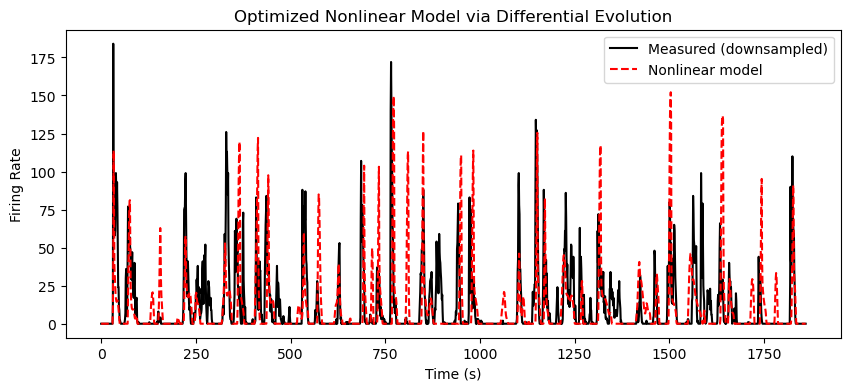

In [ ]:
# Define the combined nonlinear model.
def nonlinear_model(Lout, gain, max_rate, y, theta=30):

    pred_sigmoid = apply_nonlinearity(Lout, method='sigmoid', gain=gain, max_rate=max_rate, y=y)
    # Apply the threshold-linear nonlinearity with fixed theta.
    pred = apply_nonlinearity(pred_sigmoid, method='threshold_linear', theta=theta)
    return pred


# Define the objective (error) function (mean squared error) for optimization.
def mse_objective(params, Lout, firing_measured):
    gain, max_rate, y = params  # theta is fixed
    theta = 20
    pred = nonlinear_model(Lout, gain, max_rate, y, theta)
    mse = np.mean((pred - firing_measured) ** 2)
    return mse

# Set bounds for the parameters we are optimizing: gain, max_rate, and y.
bounds = [
    (0.00001, 0.03),   # gain: around 0.02
    (200, 300),     # max_rate: around 250
    (-800, 700)    # y: around -150
]

# Use differential evolution to optimize the parameters.
result = differential_evolution(
    mse_objective, 
    bounds,
    args=(LoutGC, firing_rate_n),
    strategy='best1bin', 
    maxiter=10,
    popsize=15,
    tol=1e-6,
    mutation=(0.5, 1),
    recombination=0.7,
    disp=True
)

best_params = result.x
print("Optimized parameters (with theta fixed at 15):")
print("gain =", best_params[0])
print("max_rate =", best_params[1])
print("y =", best_params[2])
print("theta = 30")
print("MSE =", result.fun)

# Generate predictions using the best parameters and fixed theta=15.
predicted_firing = nonlinear_model(LoutGC, best_params[0], best_params[1], best_params[2], theta=30)

# Plot the measured (resampled) firing rate and the model prediction.
plt.figure(figsize=(10, 4))
plt.plot(t_sampling, firing_rate_n, 'k-', label='Measured (downsampled)')
plt.plot(t_sampling, predicted_firing, 'r--', label='Nonlinear model')
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate')
plt.legend()
plt.title('Optimized Nonlinear Model via Differential Evolution')
plt.show()

# opt combined nonlinearity and nolinearity

In [ ]:
def objectiveComposite(params, train=True):
    try:
        # Unpack all parameters
        B, tau, gain, max_rate, y, theta  = params
        A = 1
        pnratio = 1

        # Modify the temporal receptive field using pnratio.
        reversed_temp_rf_fit = np.concatenate(
            (reversed_temp_rfTemp[0:8], reversed_temp_rfTemp[8:] * pnratio)
        )
        
        # Run the model to generate the linear-nonlinear output with gain control.
        spike_trainGCfit = []
        spike_trains_modelvp = []
        spike_trains_model = []
        
        LoutGCfit = linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s,
                                  A_c, A_s, stimuli, reversed_temp_rf_fit, 'SFfitting', rf_estimated)
        LoutGCfit, g = gain_control(LoutGCfit, B, tau)
        LNoutGCfit = apply_nonlinearity(
            apply_nonlinearity(LoutGCfit, 'sigmoid', gain=gain, max_rate=max_rate, y=y),
            method='threshold_linear', theta=theta)
        time_bin = 1 / time_para
        if LNoutGCfit[0] > 30:
            return 1e10
        # Generate model spike trains over 30 trials.
        for trial in range(30): 
            spikingindx = resample_and_generate_spikes(LNoutGCfit, time_bin)
            spike_trainGCfit.append(np.where(spikingindx > 0))
            st_modelvp = SpikeTrain(np.array(spike_trainGCfit[trial]).flatten() / 54 * 10 * ms, t_stop=31000)
            spike_trains_modelvp.append(st_modelvp)
        
        # Convert spike indices into model spike train arrays (for EMD).
        for spikes in spike_trainGCfit:
            st_model = np.array(spikes).flatten() / 54 * 10
            spike_trains_model.append(st_model)
            
        # Check for empty spike trains.
        if any(len(st) == 0 for st in spike_trains_model):
            return 1e10
        if any(len(st) == 0 for st in spike_trains_modelvp):
            return 1e10

        # Select appropriate reference spike trains based on the train flag.
        if train:
            ref_spike_trains_EMD = [spike_trains_nemd[i] for i in range(len(spike_trains_nemd)) if i % 2 == 0]
            ref_spike_trains_VP  = [spike_trains_n[i] for i in range(len(spike_trains_n)) if i % 2 == 0]
        else:
            ref_spike_trains_EMD = [spike_trains_nemd[i] for i in range(len(spike_trains_nemd)) if i % 2 == 1]
            ref_spike_trains_VP  = [spike_trains_n[i] for i in range(len(spike_trains_n)) if i % 2 == 1]

        # Composite objective for EMD.
        spike_trains_EMD = ref_spike_trains_EMD + spike_trains_model
        score_matrix = compute_emd_matrix(spike_trains_EMD)
        score_EMD = block_means(score_matrix, 2, 30)
        
        # Composite objective for VP.
        spike_trainsvpfit = ref_spike_trains_VP + spike_trains_modelvp
        vp_matrix = victor_purpura_distance(spike_trainsvpfit, q)
        score_VP = block_means(vp_matrix, 2, 30)
        
        # Composite score: lower is better.
        composite_score = score_EMD[0, 1] / score_EMD[0, 0] + score_VP[0, 1] / score_VP[0, 0]
        return composite_score

    except Exception as e:
        print("Error in objectiveComposite with params", params, ":", e)
        return 1e10
    
def objective_wrapper(params):
    return objectiveComposite(params, train=True)
# Define bounds for all parameters:
bounds = [
    (0.00001, 1),      # B
    (3, 25),          # tau
    (0.0001, 0.1),    # gain
    (150, 300),       # max_rate
    (-1000, 800),       # y
    (-600,500)          # theta
]

# Prepare lists to store iteration data.
iterationsC = []
errors_trainC = []
errors_evalC = []

def callbackFC(xk, convergence):
    # Record current iteration number.
    iteration = len(iterationsC) + 1
    # Compute composite errors on training and evaluation sets.
    train_error = objectiveComposite(xk, train=True)
    eval_error = objectiveComposite(xk, train=False)
    iterationsC.append(iteration)
    errors_trainC.append(train_error)
    errors_evalC.append(eval_error)
    print(f"Iteration {iteration}: Training Error = {train_error}, Evaluation Error = {eval_error}")

# Run differential evolution using the training set for optimization.
result_de = differential_evolution(
    lambda params: objectiveComposite(params, train=True),
    bounds,
    strategy="rand1bin",   # Fast, broad search initially
    maxiter=800,          # Adjust iterations as needed
    popsize = 15,
    mutation=(0.5, 1),
    recombination=0.95,
    disp=True,
    callback=callbackFC,
)

optimal_params = result_de.x
print("Optimal parameters found:")
print("B       =", optimal_params[0])
print("tau     =", optimal_params[1])
print("gain    =", optimal_params[2])
print("max_rate=", optimal_params[3])
print("y       =", optimal_params[4])
print("theta   =", optimal_params[5])


differential_evolution step 1: f(x)= 5.098036801240124
Iteration 1: Training Error = 5.354538290723996, Evaluation Error = 5.361078825393335
differential_evolution step 2: f(x)= 5.098036801240124
Iteration 2: Training Error = 5.205265815330556, Evaluation Error = 5.56126999593749
differential_evolution step 3: f(x)= 5.098036801240124
Iteration 3: Training Error = 5.254937005970541, Evaluation Error = 5.311970722611079
differential_evolution step 4: f(x)= 5.098036801240124
Iteration 4: Training Error = 5.364189302127892, Evaluation Error = 5.283142432787333
differential_evolution step 5: f(x)= 5.098036801240124
Iteration 5: Training Error = 5.123914335971494, Evaluation Error = 5.526416241186887
differential_evolution step 6: f(x)= 5.098036801240124
Iteration 6: Training Error = 5.616176389120648, Evaluation Error = 5.463654418457237
differential_evolution step 7: f(x)= 5.098036801240124
Iteration 7: Training Error = 5.4438904756430055, Evaluation Error = 5.2926624264624476
differential

In [ ]:

# Plot both training and evaluation error curves over iterations.
plt.figure(figsize=(10, 6))
plt.plot(iterationsC, errors_trainC, label="Training Error", marker='o')
plt.plot(iterationsC, errors_evalC, label="Evaluation Error", marker='o')
plt.xlabel("Iterations")
plt.ylabel("Error (Lower is Better)")
plt.title("Error vs. Iterations During Composite Optimization")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# B       = 0.37304849439689425
# tau     = 23.17564637791108
# gain    = 0.008955711208160765
# max_rate= 244.20270111740393
# y       = 256.7731021338907
# theta   = 203.11685951533403

In [ ]:
# gain = 0.007405645934417652
# max_rate = 150.0
# y = -400
# A     = 0.8499933511498123
# B     = 0.0001957834788429702
# tau   = 9.995996093979702
# pnratio = 1.0328866599115238


In [ ]:

# theta = 20
# A     = 0.25647146282835576
# B     = 3.7617576835791144e-05
# tau   = 22.270442267716334
# pnratio = 0.5687064327358631
# gain = 0.00584
# max_rate = 200
# y = -400

In [ ]:
# Optimal parameters found:2
# A     = 0.8741020654095416
# B     = 0.0011924248002383453
# tau   = 8.053734308855226
# pnratio = 1.2453622960617898
# Objective score = 717.358520121614